In [29]:
import torch

In [4]:
device = torch.empty(1).device

In [5]:
a = torch.load('/home/gridsan/gschuette/binz_group_shared/zlao/for_greg/run_scripts_1/chr_1_0.pt',map_location=device)

In [6]:
a

tensor([[[ 0.0608,  3.5931, -1.4655,  ...,  0.8881, -0.2752, -2.6679],
         [-1.0577,  3.9899,  0.2972,  ...,  2.0217,  0.1286, -0.7900],
         [-1.1141,  2.9361, -2.5720,  ...,  1.2188, -2.4308,  2.5277],
         ...,
         [-0.6375,  1.2439,  0.3090,  ..., -1.1241,  1.1532,  2.7986],
         [ 1.8492,  1.3955, -2.4614,  ..., -1.2247, -0.7906,  1.1656],
         [-1.3701,  0.8691,  1.1013,  ...,  0.1064,  2.1044,  1.5171]]],
       requires_grad=True)

In [7]:
a.shape

torch.Size([1, 260, 256])

In [13]:
import os

In [22]:
main_dir = '/home/gridsan/gschuette/binz_group_shared/zlao/for_greg/'
indices = {}
indices['all'] = []
for folder in os.listdir(main_dir):
    sub_dir = main_dir + folder + '/'
    chrom = folder.split('_')[-1]
    indices[chrom] = []
    for file in os.listdir(sub_dir):
        indices[chrom].append( int(file.split('_')[-1].split('.')[0]) )
        indices['all'].append(indices[chrom][-1])
    indices[chrom].sort()
    indices[chrom] = torch.tensor(indices[chrom])
indices['all'].sort()
indices['all'] = torch.tensor(indices['all']) 

In [24]:
indices['all'].max()

tensor(11503)

In [28]:
(indices[chrom][1:] - indices[chrom][:-1]).unique()

tensor([1])

In [1]:
import pandas as pd
import torch 
import os 

# Where are files located? 
embeddings_main_dir = '../../../data/raw_embeddings/'

# Load Zhuohan's dictionary that relates file indices to genomic regions
info_dict = pd.read_pickle(embeddings_main_dir + 'my_dict.pickle')

# The following function parses the filenames to provide the index within 
# Zhuohan's dictionary, allowing us to extract relevant information. 
parse_filename = lambda f: int( f.split('_')[-1].split('.')[0] )

# We will store this data in the CPU RAM except when being actively used, so we'll map all the files to
# the CPU upon loading to save it there later. 
device = torch.device('cpu')

# Load all of the data in the usual ordering of chromosomes.
# Keep track of region length, chromosome number, & starting genomic position
# to aid with indexing in the dataloader. 
chroms = [f'{k}' for k in range(1,23)]
chroms.append('X')
data = []
region_size = [] 
chrom_idx = []   
start_idx = []
for chrom in chroms: 

    # Define some objects used repeatedly in the following loop.
    subdir = embeddings_main_dir + f'run_scripts_{chrom}/'
    filepath = lambda idx: subdir + f'chr_{chrom}_{idx}.pt'

    # The the files that exist 
    filenames = os.listdir(subdir)

    # Indices are easy to obtain 
    idxs = [parse_filename(fn) for fn in filenames]

    # They can be used in one liners to improve speed a bit.
    
    # No need to append to chrom_idx repeatedly in the inner loop
    chrom_idx.extend([chrom for _ in range(len(filenames))])

    # Remove the gradient information upon loading data since it serves no purpose downstream. 
    data.extend([ 
        torch.load(filepath(idx),map_location=device).requires_grad_(False) for idx in idxs
    ])
    
    region_size.extend([
        info_dict[chrom][idx,1]-info_dict[chrom][idx,0] for idx in idxs
    ])

    start_idx.extend([
        info_dict[chrom][idx,0] for idx in idxs
    ])

# Place values into a dataframe so that we can easily sort them. 
embed_df = pd.DataFrame()
embed_df['Region_Size'] = region_size
embed_df['Chromosome'] = chrom_idx
embed_df['Genomic_Index'] = start_idx
embed_df['Data'] = data
del region_size, chrom_idx, start_idx, data

# Organize the data by sorting
idx_cols = ['Region_Size','Chromosome','Genomic_Index']
embed_df.sort_values(by=idx_cols,axis='index',ignore_index=True,inplace=True)

# TEMPORARY. Just in case the following code fails when running. 
embed_df.to_hdf('data.hdf',complevel=9)

# Create a MultiIndex for easier fetching of data inside of the DataLoader later on. 
embed_df.index = pd.MultiIndex.from_tuples(
    list(map(tuple,embed_df[idx_cols].values)),
    names=idx_cols
)

# Drop the now-redundant columns
embed_df.drop(columns=idx_cols,inplace=True)

# Save the processed data to the canonical HDF file
embed_df.to_hdf(
    data_filepath,
    key='Embeddings',
    complevel=9,
    
)


KeyboardInterrupt: 

In [1]:
import pandas as pd
import torch 
import os 
from multiprocessing import Pool

processes_count = 2

pool = Pool(processes_count) 

def load_data(chrom,idx,data_dict):
    data_dict[idx] = torch.load(filepath(chrom,idx),map_location=device).requires_grad_(False)

# Where are files located? 
embeddings_main_dir = '../../../data/raw_embeddings/'

# Load Zhuohan's dictionary that relates file indices to genomic regions
info_dict = pd.read_pickle(embeddings_main_dir + 'my_dict.pickle')

# The following function parses the filenames to provide the index within 
# Zhuohan's dictionary, allowing us to extract relevant information. 
parse_filename = lambda f: int( f.split('_')[-1].split('.')[0] )

# This is used when loading data
filepath = lambda chrom,idx: subdir + f'chr_{chrom}_{idx}.pt'

# We will store this data in the CPU RAM except when being actively used, so we'll map all the files to
# the CPU upon loading to save it there later. 
device = torch.device('cpu')

# Load all of the data in the usual ordering of chromosomes.
# Keep track of region length, chromosome number, & starting genomic position
# to aid with indexing in the dataloader. 
chroms = [f'{k}' for k in range(1,23)]
chroms.append('X')
data = []
region_size = [] 
chrom_idx = []   
start_idx = []
for chrom in chroms: 

    # Define some objects used repeatedly in the following loop.
    subdir = embeddings_main_dir + f'run_scripts_{chrom}/'

    # Indices are easy to obtain from the list of files
    idxs = [parse_filename(fn) for fn in os.listdir(subdir)]

    # The indices can be used in one liners to improve speed a bit.
    
    # Initialize an object to hold data as it's loaded in parallel
    # in an organized fashion. 
    data_dict = {f'{idx}':None for idx in idxs}

    # Load the data 
    pool.map(load_data, [(chrom,idx,data_dict) for idx in idxs[:2]])

    break
    
    
    # No need to append to chrom_idx repeatedly in the inner loop
    chrom_idx.extend([chrom for _ in range(len(filenames))])

    # Remove the gradient information upon loading data since it serves no purpose downstream. 
    data.extend([ 
        torch.load(filepath(idx),map_location=device).requires_grad_(False) for idx in idxs
    ])
    
    region_size.extend([
        info_dict[chrom][idx,1]-info_dict[chrom][idx,0] for idx in idxs
    ])

    start_idx.extend([
        info_dict[chrom][idx,0] for idx in idxs
    ])

# Place values into a dataframe so that we can easily sort them. 
embed_df = pd.DataFrame()
embed_df['Region_Size'] = region_size
embed_df['Chromosome'] = chrom_idx
embed_df['Genomic_Index'] = start_idx
embed_df['Data'] = data
del region_size, chrom_idx, start_idx, data

# Organize the data by sorting
idx_cols = ['Region_Size','Chromosome','Genomic_Index']
embed_df.sort_values(by=idx_cols,axis='index',ignore_index=True,inplace=True)

# TEMPORARY. Just in case the following code fails when running. 
embed_df.to_hdf('data.hdf',complevel=9)

# Create a MultiIndex for easier fetching of data inside of the DataLoader later on. 
embed_df.index = pd.MultiIndex.from_tuples(
    list(map(tuple,embed_df[idx_cols].values)),
    names=idx_cols
)

# Drop the now-redundant columns
embed_df.drop(columns=idx_cols,inplace=True)

# Save the processed data to the canonical HDF file
embed_df.to_hdf(
    data_filepath,
    key='Embeddings',
    complevel=9,
    
)


Process ForkPoolWorker-1:
Process ForkPoolWorker-2:
Traceback (most recent call last):
  File "/state/partition1/llgrid/pkg/anaconda/python-LLM-2023b/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/state/partition1/llgrid/pkg/anaconda/python-LLM-2023b/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/state/partition1/llgrid/pkg/anaconda/python-LLM-2023b/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/state/partition1/llgrid/pkg/anaconda/python-LLM-2023b/lib/python3.10/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/state/partition1/llgrid/pkg/anaconda/python-LLM-2023b/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/state/partition1/llgrid/pkg/anaconda/python-LLM-2023b/lib/python3.10/multiprocessing/queues.py",

KeyboardInterrupt: 

In [3]:
load_data

<function __main__.load_data(chrom, idx, data_dict)>

In [29]:
import pandas as pd

a = pd.read_csv('../../../data/genomic_regions.tsv',sep='\t')

In [2]:
import pandas as pd
import torch 
import os 

# Where are files located? 
embeddings_main_dir = '../../../data/raw_embeddings/'
tsv_filepath = '../../../data/genomic_regions.tsv'

# We will store this data in the CPU RAM except when being actively used, so we'll map all the files to
# the CPU upon loading to save it there later. 
device = torch.device('cpu') 

# Load the tsv file used to generate data, whose ordering is relevant to the genomic region/chromosome. 
regions_df = pd.read_csv(tsv_filepath,sep='\t',index_col=0)

# Break the tsv file into multiple DataFrames, one for each chromosome, since that's how 
# Zhuohan organized the files. Also, reset the index, as Zhuohan labeled the data files 
# by order of appearance within the context of each individual chromosome. 
# To simplify the eventual file's organization, I'll load & save the files in a sorted manner. 
subregion_dfs = {}
chroms = [f'{k}' for k in range(1,23)]
chroms.append('X')
data_dfs = []
for chrom in chroms:
    
    # Get the relevant subsection from the complete DataFrame. 
    subregion_df = regions_df[regions_df['Chromosome']==chrom].copy()

    # Reset the index for this subset, as Zhuohan labeled the data files by
    # order of appearance within the context of that chromosome. 
    subregion_df.reset_index(drop=True,inplace=True)

    # Sort the data according to Genomic Index to simplify the organization
    # of data in the eventual save file. 
    subregion_df.sort_values(by='Start',axis='index',ignore_index=False,inplace=True)
    
    # Load data in the order of this now-sorted information, which is contained in a subdirectory
    filepath = lambda idx: embeddings_main_dir + f'run_scripts_{chrom}/chr_{chrom}_{idx}.pt'
    idxs_to_drop = []
    data = []
    n=0
    for idx,row in subregion_df.iterrows():
        # Remove gradient information upon loading since it serves no purpose for 
        # its downstream usage. 
        try: 
            data.append( torch.load(filepath(idx),map_location=device).requires_grad_(False) )
        except: 
            # File doesn't exist 
            idxs_to_drop.append(idx) 
        n+=1
        if n>1000:
            break
    subregion_df.drop(index=idxs_to_drop,inplace=True)

    index = pd.MultiIndex.from_tuples(
        list(map(tuple,subregion_df[['Chromosome','Start']].values[:len(data),:])),
        names=['Chromosome','Start']
    )
    break

    index = pd.MultiIndex.from_tuples(
        list(map(tuple,subregion_df[['Chromosome','Start']].values)),
        names=['Chromosome','Start']
    )

    data_df = pd.DataFrame(data,index=index)
    data_df['Chromosome'] = chrom 
    data_dfs.append(data_df)
    del data_df 

del regions_df

# Place all the data into a DataFrame object that contains columns for 
# genomic index of starting position, chromosome label, and the data
data_df = pd.concat(data_dfs,axis=0,ignore_index=False) 

#processed_df = pd.concat(subregion_dfs,axis=0,ignore_index=True)[['Chromosome','Start']]
#processed_df.rename(columns={'Start':'Genomic_Index'},inplace=True)
#processed_df['Data'] = data




NameError: name 'data_df' is not defined

In [ ]:
data_df

In [3]:
t = pd.DataFrame()
t['Data'] = data
t.index = index

In [23]:
t[:10].index

MultiIndex([('1', 800000),
            ('1', 820000),
            ('1', 840000),
            ('1', 860000),
            ('1', 880000),
            ('1', 900000),
            ('1', 920000),
            ('1', 940000),
            ('1', 960000),
            ('1', 980000)],
           names=['Chromosome', 'Start'])

In [27]:
import time
tt = time.time()
idx = t[0:20:2].index
t.loc[idx].values
tt-= time.time()
tt*= -1 
print(tt)

0.002743244171142578


In [18]:
a = t.loc[('1',800000)].values[0][0,...]

In [19]:
a.shape

torch.Size([260, 256])

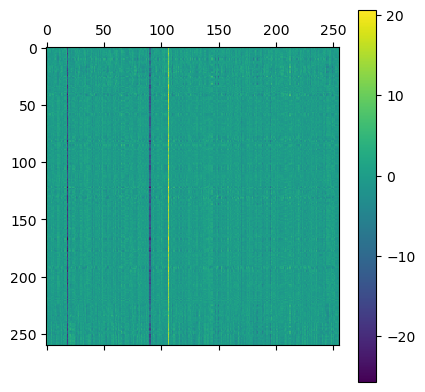

In [20]:
import matplotlib.pyplot as plt
plt.matshow(a) 
plt.colorbar()

In [129]:
embeddings_main_dir = '../../../data/raw_embeddings/'
for chrom in zhuohan_dict: 

    idxs = [ int(fn.split('_')[-1].split('.')[0]) for fn in os.listdir(embeddings_main_dir+f'run_scripts_{chrom}/') ]

    assert len(idxs) == len(zhuohan_dict[chrom][:,0])

    

AssertionError: 

In [132]:
chrom = '2'
path = lambda idx: embeddings_main_dir+f'run_scripts_{chrom}/chr_{chrom}_{idx}.pt'
os.path.exists(path(0))

True

In [139]:
a = [1,2,3,4]
a.remove(5)
a

ValueError: list.remove(x): x not in list

In [140]:
embeddings_main_dir = '../../../data/raw_embeddings/'
missing_files = ['Chrom\tIndex']
with open('missing_files.tsv', 'a') as f:
    f.write('Chrom\tIndex\n')
    for chrom in zhuohan_dict: 
    
        path = lambda idx: embeddings_main_dir+f'run_scripts_{chrom}/chr_{chrom}_{idx}.pt'
        idxs = [ int(fn.split('_')[-1].split('.')[0]) for fn in os.listdir(embeddings_main_dir+f'run_scripts_{chrom}/') ]
        for k in range(len(zhuohan_dict[chrom][:,0])):
            try:
                idxs.remove(k)
            except:
                f.write(f'{chrom}\t{k}\n')

In [133]:
embeddings_main_dir = '../../../data/raw_embeddings/'
missing_files = ['Chrom\tIndex']
for chrom in zhuohan_dict: 

    path = lambda idx: embeddings_main_dir+f'run_scripts_{chrom}/chr_{chrom}_{idx}.pt'
    for k in range(len(zhuohan_dict[chrom][:,0])):

        if not os.path.exists(path(k)):
            missing_files.append(f'{chrom}\t{k}')
missing_files
    

KeyboardInterrupt: 

In [115]:
pickle_fp = '../../../data/raw_embeddings/my_dict.pickle'
tsv_filepath = '../../../data/genomic_regions.tsv'

zhuohan_dict = pd.read_pickle(pickle_fp)
regions_df = pd.read_csv(tsv_filepath,sep='\t',index_col=0)

# Ensure all chroms present
zh_keys = list(zhuohan_dict.keys())
rg_keys = regions_df['Chromosome'].unique()
assert len(zh_keys) == len(rg_keys) 
for chrom in zh_keys: 
    assert chrom in rg_keys 

# Determine which regions are missing in Zhuohan's files, 
# and which regions are errantly included 
missing_regions = [[],[]]
errant_regions = [[],[]]
for chrom in rg_keys: 
    want = regions_df[regions_df['Chromosome']==chrom][['Start','Stop']]#.rename(columns={'Start':'Start_True','Stop':'Stop_True'})
    
    want.merge(
        pd.DataFrame({'Start':zhuohan_dict[chrom][:,0],'Stop':zhuohan_dict[chrom][:,1]}),
        indicator=True
    )
    
    break 
want

,Start,Stop
0,1420000,2720000
1,1440000,2740000
2,1460000,2760000
3,1480000,2780000
4,1500000,2800000
...,...,...
136783,119560000,120860000
136784,119580000,120880000
136785,144620000,145920000
136786,144640000,145940000


In [113]:
pd.DataFrame({'Start':zhuohan_dict[chrom][:,0],'Stop':zhuohan_dict[chrom][:,1]})

,Start,Stop
0,780,2080
1,800,2100
2,820,2120
3,840,2140
4,860,2160
...,...,...
10769,247680,248980
10770,247700,249000
10771,247720,249020
10772,247740,249040


In [ ]:
pd.read_pickle()

In [85]:
import pickle
zdict = pickle.load(open('../../../data/raw_embeddings/my_dict.pickle','rb'))
zdict

{'1': array([[   780,   2080],
        [   800,   2100],
        [   820,   2120],
        ...,
        [247720, 249020],
        [247740, 249040],
        [247760, 249060]]),
 '2': array([[     0,   1300],
        [    20,   1320],
        [    40,   1340],
        ...,
        [241800, 243100],
        [241820, 243120],
        [241840, 243140]]),
 '3': array([[    60,   1360],
        [    80,   1380],
        [   100,   1400],
        ...,
        [196580, 197880],
        [196600, 197900],
        [196620, 197920]]),
 '4': array([[    20,   1320],
        [    40,   1340],
        [    60,   1360],
        ...,
        [189720, 191020],
        [189740, 191040],
        [189760, 191060]]),
 '5': array([[     0,   1300],
        [    20,   1320],
        [    40,   1340],
        ...,
        [179400, 180700],
        [179420, 180720],
        [179440, 180740]]),
 '6': array([[   200,   1500],
        [   220,   1520],
        [   240,   1540],
        ...,
        [169600, 170900]

In [86]:
len(zdict['1'])

10774

In [82]:
import numpy as np
chroms = [f'{k}' for k in range(1,23)]
for chrom in chroms: 
    missing = np.ones(len(regions_df[regions_df['Chromosome']==chrom]),dtype=bool)
    for filename in os.listdir(embeddings_main_dir+f'run_scripts_{chrom}'):
        missing[int( filename.split('_')[-1].split('.')[0] )] = False

    missing = np.where(missing)[0]
    if len(missing) > 0: 
        msg = f'Chromosome {chrom} is missing files for '
        for m in missing: 
            msg+= f'{m}, '
        print(msg)
        

Chromosome 1 is missing files for 10768, 10769, 10770, 10771, 10772, 10773, 
Chromosome 2 is missing files for 11504, 11505, 11506, 11507, 11508, 11509, 11510, 11511, 11512, 11513, 11514, 11515, 11516, 11517, 11518, 11519, 11520, 11521, 11522, 11523, 11524, 11525, 11526, 11527, 11528, 11529, 11530, 11531, 11532, 11533, 11534, 11535, 11536, 11537, 11538, 11539, 11540, 11541, 11542, 11543, 11544, 11545, 11546, 11547, 11548, 11549, 11550, 11551, 
Chromosome 4 is missing files for 9220, 9221, 9222, 9223, 9224, 9225, 9226, 9227, 9228, 9229, 9230, 9231, 9232, 9233, 9234, 9235, 9236, 9237, 9238, 9239, 9240, 9241, 9242, 9243, 9244, 9245, 9246, 9247, 9248, 9249, 9250, 9251, 9252, 9253, 9254, 9255, 9256, 9257, 9258, 9259, 9260, 9261, 9262, 
Chromosome 6 is missing files for 8241, 8242, 8243, 8244, 8245, 8246, 8247, 
Chromosome 8 is missing files for 6855, 6856, 6857, 6858, 6859, 6860, 6861, 6862, 6863, 6864, 6865, 6866, 6867, 6868, 6869, 6870, 6871, 6872, 6873, 6874, 6875, 6876, 6877, 6878, 6879

In [69]:
for i,_ in subregion_dfs['1'].iterrows():
    print(i)
    break

10768


In [ ]:
import pandas as pd
import torch 
import os 

# Where are files located? 
zhuohan_data_dir = '/home/gridsan/gschuette/binz_group_shared/zlao/for_greg/'
tsv_filepath = '../../../data/genomic_regions.tsv'

# We will store this data in the CPU RAM except when being actively used, so we'll map all the files to
# the CPU upon loading to save it there later. 
device = torch.device('cpu') 

# Load the tsv file used to generate data, whose ordering is relevant to the genomic region/chromosome. 
regions_df = pd.read_csv(tsv_filepath,sep='\t',index_col=0)

# Break the tsv file into multiple DataFrames, one for each chromosome, since that's how 
# Zhuohan organized the files. Also, reset the index, as Zhuohan labeled the data files 
# by order of appearance within the context of each individual chromosome. 
subregion_dfs = {}
for chrom in regions_df['Chromosome'].unique():

    # Get the relevant subsection from the complete DataFrame. 
    subregion_dfs[chrom] = regions_df[regions_df['Chromosome']==chrom].copy()

    # Reset the index for this subset, as Zhuohan labeled the data files by
    # order of appearance within the context of that chromosome. 
    subregion_dfs[chrom].reset_index(ignore_index=True,inplace=True)

    # Sort the data according to Genomic Index to simplify the organization
    # of data in the eventual save file. 
    subregion_dfs[chrom].sort_values(by='Start',axis='index',ignore_index=False,inplace=True)
del regions_df

# Load 


data = []




for folder in os.listdir(zhuohan_data_dir):

    # Define an object representing the full filepath of this subfolder
    # for simpler code below. 
    sub_dir = main_dir + folder + '/'

    # The folder name indicates the chromosome whose genomic region was analyzed. 
    chrom = folder.split('_')[-1]

    # Need the index of subregions to determine the relevant starting path 
    # for each of the files. 
    subregion_df = regions_df[regions_df['Chromosome']==chrom].copy()
    subregion_df.reset_index(ignore_index=True,inplace=True)

    # Load all of the files and keep track of the genomic region 
    # they correspond to in an indexing object. 
    data = []
    multi_index = []
    for i,filename in enumerate(os.listdir(sub_dir)):
        filepath = sub_dir + filename
        idx = int(file.split('_')[-1].split('.')[0])
        genomic_index = subregion_df.loc[idx,'Start']

        temp = torch.load(filepath,)
        data.append()

In [60]:
type(a.loc[0,'Start'])

numpy.int64

In [46]:
data = torch.load('/home/gridsan/gschuette/binz_group_shared/zlao/for_greg/run_scripts_1/chr_1_0.pt',map_location=device).requires_grad_(False)

In [47]:
data.shape

torch.Size([1, 260, 256])

In [48]:
test_df = pd.DataFrame(
    data={'Matrices':[data,data]},
    index=[1,2]
)

In [55]:
test_df.loc[1,'Matrices'].dtype

torch.float32

In [1]:
import pandas as pd
data_dict = pd.read_pickle('../Zhuohan_Data/data_files_X.pkl')

In [2]:
data = pd.DataFrame(data_dict)

In [4]:
data.iloc[:5]

,data,idxs,region_size,start_idx
0,"[[[tensor(-1.2399), tensor(2.3151), tensor(-1....",0,1300,220
1,"[[[tensor(1.5264), tensor(1.0032), tensor(-1.8...",1,1300,240
2,"[[[tensor(-0.6710), tensor(2.3667), tensor(0.3...",2,1300,260
3,"[[[tensor(1.6498), tensor(-1.6166), tensor(0.1...",3,1300,280
4,"[[[tensor(-0.0945), tensor(-1.1250), tensor(0....",4,1300,300


In [2]:
import pandas as pd
chrom='X'
idx_cols = ['Region_Length','Genomic_Index']
embed_df = pd.DataFrame(
    pd.read_pickle(f'../Zhuohan_Data/data_files_{chrom}.pkl')
).rename(
    columns={'data':'Data','region_size':'Region_Length','start_idx':'Genomic_Index'}
).drop(
    columns='idxs'
).astype( 
    {'Region_Length':int,'Genomic_Index':int}
).sort_values(
    by=idx_cols,
    axis='index',
    ignore_index=True
)

In [7]:
dest_fp = lambda chrom: f'../Zhuohan_Data/embeddings_{chrom}.h5'#'../../data/processed_data.hdf5'
embed_df[:1].to_hdf(
    dest_fp(chrom),
    key='Embeddings',
    complevel=0,
    format='table',
    append=False,
    mode='w'
)

TypeError: Cannot serialize the column [Data]
because its data contents are not [string] but [mixed] object dtype

In [ ]:
embed_df['start_idx'].max()

In [1]:
import pandas as pd
import time

t = -time.time()
a = pd.read_pickle('../Zhuohan_Data/embeddings_1.tar.gz')
t+= time.time()
t

40.81873440742493

In [3]:
a[:1]

,,,Data
Region_Length,Chromosome,Genomic_Index,
1300000,1,780000,"[[[tensor(0.0608), tensor(3.5931), tensor(-1.4..."


In [24]:
import numpy as np
b = a['Data'].values.astype(np.float32)

ValueError: only one element tensors can be converted to Python scalars

In [32]:
import torch

b = a.loc[(1300000,'1',780000)].values[0]

In [58]:
a.loc[(1300000,'1',780000)]

Data    [[[tensor(0.0608), tensor(3.5931), tensor(-1.4...
Name: (1300000, 1, 780000), dtype: object

In [39]:
a.loc[(1300000,'1',780000),'Data']# = a.loc[(1300000,'1',780000)].values[0]

tensor([[[ 0.0608,  3.5931, -1.4655,  ...,  0.8881, -0.2752, -2.6679],
         [-1.0577,  3.9899,  0.2972,  ...,  2.0217,  0.1286, -0.7900],
         [-1.1141,  2.9361, -2.5720,  ...,  1.2188, -2.4308,  2.5277],
         ...,
         [-0.6375,  1.2439,  0.3090,  ..., -1.1241,  1.1532,  2.7986],
         [ 1.8492,  1.3955, -2.4614,  ..., -1.2247, -0.7906,  1.1656],
         [-1.3701,  0.8691,  1.1013,  ...,  0.1064,  2.1044,  1.5171]]])

In [50]:
a.index.get_level_values('Chromosome','Genomic_Index')

KeyError: "Level ['Chromosome', 'Genomic_Index'] not found"

In [10]:
import pandas as pd

def load_embeddings(directory,chroms):
    '''
    chroms: Either None or list of chromosomes to load. 
    '''

    if chroms is None: 
        chroms = [f'{k}' for k in range(1,23)]
        chroms.append('X')

    if directory[-1] != '/':
        directory = directory + '/' 

    filepath = lambda chrom: directory + f'chrom_{chrom}.tar.gz'

    dfs = []
    for chrom in chroms: 
        dfs.append( pd.read_pickle(filepath(chrom)) )

    return pd.concat(dfs)


class EmbeddedRegions:

    def __init__(
        self,
        directory,
        chroms=None
    ):
        self.data = load_embeddings(directory,chroms)

    @property
    def index(self):
        return self.data.index

    @property
    def chrom_index(self):
        return self.index.get_level_values('Chromosome')

    @property
    def genomic_index(self):
        return self.index.get_level_values('Genomic_Index')

    @property
    def length_index(self):
        return self.index.get_level_values('Region_Length')

    def __len__(self):
        return len(self.data) 

    def drop(
        self,
        region_length,
        chrom,
        genomic_index
    ): 
        # Doing this in place is WAY faster than out of place. 
        self.data.drop(index=(region_length,chrom,genomic_index),inplace=True)

    def append(
        self,
        new_embedded_regions # EmbeddedRegions object or iterable full of them
    ):
        y = new_embedded_regions

        if type(y) == EmbeddedRegions:
            self.data = pd.concat([self.data,y.data])
        elif hasattr(y, '__iter__'):
            for i,obj in enumerate(y):
                assert type(obj) == EmbeddedRegions, \
                f'Expected iterable to contain EmbeddedRegions objects, but it contains {type(obj)} at position {i}.'
            self.data = pd.concat([self.data,*[yy.data for yy in y]])
        else:
            raise Exception('EmbeddedRegions.append must receive another EmbeddedRegions object or an iterable of them')

    def fetch(
        self,
        region_length, # An int. Denotes the lenght of the region being considered 
        chrom,         # A string
        genomic_index  # An int, denotes start of region in bp position (each chromosome indexed independently)
    ):
        return self.data.loc[(region_length,chrom,genomic_index),'Data']

    def ifetch(
        self,
        idx 
    ):
        '''
        Return the data at a specific index
        '''
        return self.data.iloc[idx].values[0]
    

In [11]:
embeddings = EmbeddedRegions('../../../data/embeddings/',chroms=['X'])

In [12]:
dir(embeddings) 

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'append',
 'chrom_index',
 'data',
 'drop',
 'fetch',
 'genomic_index',
 'ifetch',
 'index',
 'length_index']

In [13]:
embeddings.ifetch(25000)

IndexError: single positional indexer is out-of-bounds

In [95]:
import time
iidx = 100

def loc1(idx):
    t = -time.time()
    data = embeddings.data.loc[idx,'Data']
    t+= time.time()
    return data, t

def loc2(idx):
    t = -time.time()
    data = embeddings.data.loc[idx].values[0]
    t+= time.time()
    return data, t

def iloc1(idx):
    t = -time.time()
    data = embeddings.data.loc[embeddings.index[idx]].values[0]
    t+= time.time()
    return data, t

def iloc2(idx):
    t = -time.time()
    data = embeddings.data.iloc[idx].values[0]
    t+= time.time()
    return data, t

'''

idx = embeddings.index[iidx]
t = -time.time()
a = embeddings.fetch(*idx)
t+= time.time()
print(f'fetch function: {t}s')

import time
t = -time.time()
b = embeddings.ifetch(iidx)
t+= time.time()
print(f'ifetch function: {t}s')

import time
t = -time.time()
c = embeddings.data.iloc[iidx].values[0]
t+= time.time()
print(f'iloc function: {t}s')

import time
t = -time.time()
d = embeddings.data.loc[idx].values[0]
t+= time.time()
print(f'loc function: {t}s')

'''

t1 = []
t2 = []
t3 = []
t4 = []
t5 = []
for i,idx in enumerate(range(0,2000,2)):
    iidx = embeddings.index[idx]

    a,t = loc1(iidx)
    t1.append(t)
    b,t = loc2(iidx)
    t2.append(t)
    c,t = iloc1(idx)
    t3.append(t)
    d,t = iloc2(idx)
    t4.append(t)

    iidx = embeddings.index[idx:idx+64].tolist()
    t = -time.time()
    #e = embeddings.data.loc[iidx,'Data'].values
    e = torch.stack([*embeddings.data.loc[iidx,'Data'].values],dim=0)
    t+= time.time()
    t5.append(t)
    
    if i < 10:
        assert (a == b).all()
        assert (a == c).all()
        assert (a == d).all()


In [96]:
import numpy as np
for t in [t1,t2,t3,t4,t5]:
    print(f'{np.mean(t)} +/- {np.std(t)}')

0.00016520333290100098 +/- 4.307083823969764e-05
0.00019662761688232422 +/- 0.0011688319766802032
0.00012700319290161134 +/- 1.220337968651967e-05
6.360197067260743e-05 +/- 6.744563020938599e-06
0.010893003225326539 +/- 0.012754113277160618


In [92]:
import torch
torch.stack([*embeddings.data.loc[embeddings.index[100:110].tolist(),'Data'].values],dim=0)

tensor([[[[ 2.9730e-01,  2.0404e+00,  9.5196e-01,  ...,  1.4283e+00,
            1.9611e+00, -1.6810e+00],
          [ 1.3662e+00,  1.6283e-01, -3.3016e-01,  ..., -9.3310e-01,
            1.2581e+00, -2.3191e+00],
          [ 1.4850e+00,  1.3626e+00, -1.1173e+00,  ...,  2.9756e-01,
            1.2016e+00, -2.6597e+00],
          ...,
          [-3.8377e-01,  2.4760e+00,  3.9778e-01,  ...,  7.6479e-01,
           -1.0215e-01,  7.4147e-02],
          [ 4.3383e-01,  2.0525e+00, -1.1487e-01,  ...,  7.8095e-01,
            7.3143e-01, -4.9794e-02],
          [-3.5548e-01,  1.0567e+00,  1.1781e+00,  ...,  1.0364e+00,
            7.4022e-01, -1.0899e+00]]],


        [[[ 9.2275e-01,  3.8659e-01,  4.1845e-01,  ...,  1.1279e+00,
            1.4145e+00, -1.0126e+00],
          [ 4.3345e-01,  7.3742e-01,  1.1864e+00,  ...,  1.4982e+00,
            1.4757e+00,  1.0224e-01],
          [-3.6237e-02,  7.7033e-01,  6.4011e-01,  ...,  1.7671e+00,
           -1.3215e-01,  8.1368e-01],
          ...,
   

In [77]:
embeddings.index[100:110].tolist()

[(1300000, 'X', 2220000),
 (1300000, 'X', 2240000),
 (1300000, 'X', 2260000),
 (1300000, 'X', 2280000),
 (1300000, 'X', 2300000),
 (1300000, 'X', 2320000),
 (1300000, 'X', 2340000),
 (1300000, 'X', 2360000),
 (1300000, 'X', 2380000),
 (1300000, 'X', 2400000)]

In [130]:
idx = embeddings.index[0]
t = -time.time()
embeddings.data.drop(idx)
t+= time.time()
t

0.0015912055969238281

In [137]:
hasattr([], '__iter__')

True